# Tutorial 6: Advanced Regularization – "Mixup & Cutout"

**Course:** CSEN 342: Deep Learning  
**Topic:** State-of-the-art Regularization, Custom Transforms, and Robustness

## Objective
Standard regularization (L2, Dropout) is often not enough for modern deep learning tasks. In this tutorial, we will implement two advanced data augmentation techniques discussed in class:

1.  **Cutout:** Randomly masking out square regions of the input image. This forces the model to look at the "whole" object rather than relying on a single distinctive feature (like a cat's ear).
2.  **Mixup:** Training on linear combinations of pairs of images and their labels. This encourages the model to behave linearly in-between training examples.

We will implementation these from scratch and test if they make our model more **robust** to noise.

---

## Part 1: Implementing Cutout

Cutout is a form of data augmentation where random square regions of the input image are zeroed out. We will implement this as a custom class compatible with `torchvision.transforms`.

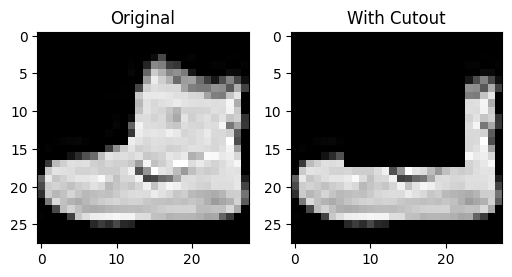

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

# Import utility functions
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from utils import download_fashion_mnist

class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            # Choose center of the hole
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

# --- Visualizing Cutout ---
# Standard transform
base_transform = transforms.Compose([transforms.ToTensor()])
# Cutout transform
cutout_transform = transforms.Compose([
    transforms.ToTensor(),
    Cutout(n_holes=1, length=16) # Cut out a 16x16 box (large!)
])
# Load Fashion-MNIST dataset
download_fashion_mnist()
dataset = torchvision.datasets.FashionMNIST(root='../data', train=True, download=False, transform=base_transform)
img, label = dataset[0]

# Apply Cutout manually to visualize
img_cutout = cutout_transform(torchvision.transforms.ToPILImage()(img))

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(img.squeeze(), cmap='gray'); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(img_cutout.squeeze(), cmap='gray'); plt.title("With Cutout")
plt.show()

---

## Part 2: Implementing Mixup

Mixup is unique because it changes not just the input $x$, but also the target label $y$. 

Instead of training on $(x_i, y_i)$, we train on:
$$ \tilde{x} = \lambda x_i + (1-\lambda) x_j $$
$$ \tilde{y} = \lambda y_i + (1-\lambda) y_j $$

Where $\lambda$ is drawn from a Beta distribution. This forces the network to output "40% T-shirt, 60% Shoe" rather than just "Shoe".

Mixing Lambda: 0.89
Label A: 1, Label B: 1


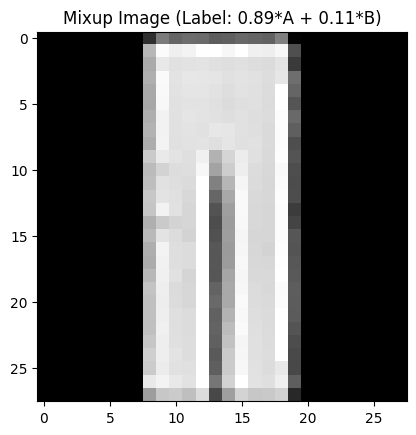

In [2]:
# Mixup Helper Functions

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    '''Loss function for mixup: linear combination of losses'''
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Visualization of Mixup
# Let's grab a batch and mix two images
loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)
data_iter = iter(loader)
images, labels = next(data_iter)

mixed_images, y_a, y_b, lam = mixup_data(images, labels, alpha=1.0, use_cuda=False)

print(f"Mixing Lambda: {lam:.2f}")
print(f"Label A: {y_a[0]}, Label B: {y_b[0]}")

plt.imshow(mixed_images[0].squeeze(), cmap='gray')
plt.title(f"Mixup Image (Label: {lam:.2f}*A + {1-lam:.2f}*B)")
plt.show()

---

## Part 3: Robustness Training Loop

We will now train two models:
1.  **Baseline:** Standard training.
2.  **Mixup:** Training using the mixup functions we defined.

We will then test both models on a **Noisy Test Set** (images with added Gaussian noise) to see which model holds up better.

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Simple CNN for speed
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.fc1 = nn.Linear(32 * 26 * 26, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

# Setup DataLoaders
trainloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
testset = torchvision.datasets.FashionMNIST(root='../data', train=False, download=False, transform=base_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

def train_mixup(model, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # --- Mixup Logic ---
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=1.0, use_cuda=torch.cuda.is_available())
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # --- Mixup Loss ---
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            loss.backward()
            optimizer.step()
            
        print(f"Epoch {epoch+1} Complete")
    return model

def train_baseline(model, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} Complete")
    return model

In [4]:
print("Training Baseline Model...")
model_base = SimpleCNN()
train_baseline(model_base, epochs=5)

print("\nTraining Mixup Model...")
model_mix = SimpleCNN()
train_mixup(model_mix, epochs=5)

Training Baseline Model...
Epoch 1 Complete
Epoch 2 Complete
Epoch 3 Complete
Epoch 4 Complete
Epoch 5 Complete

Training Mixup Model...
Epoch 1 Complete
Epoch 2 Complete
Epoch 3 Complete
Epoch 4 Complete
Epoch 5 Complete


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=21632, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

### 3.1 Robustness Test (Adding Noise)

Now we evaluate both models on the test set, but we add random Gaussian noise to the test images. A robust model should degrade gracefully.

--- Robustness Evaluation ---
Noise 0.0: Baseline=90.82%, Mixup=89.72%
Noise 0.1: Baseline=83.88%, Mixup=83.69%
Noise 0.2: Baseline=55.12%, Mixup=69.86%
Noise 0.3: Baseline=34.72%, Mixup=59.29%
Noise 0.4: Baseline=24.31%, Mixup=51.98%
Noise 0.5: Baseline=19.30%, Mixup=45.83%


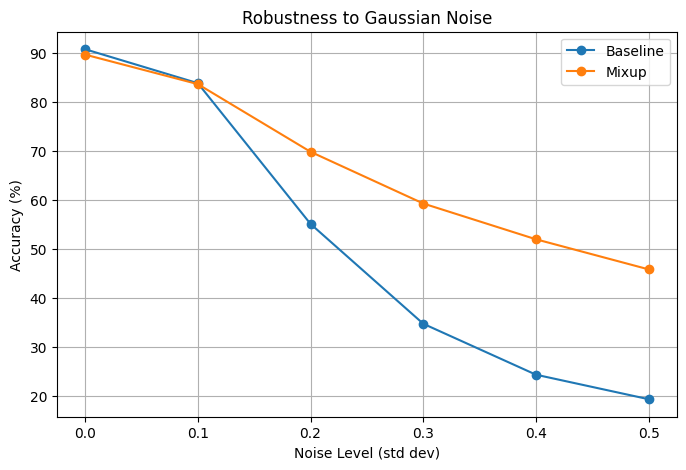

In [5]:
def evaluate_robustness(model, noise_level=0.0):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            # Add noise
            inputs = inputs + noise_level * torch.randn_like(inputs)
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

print("--- Robustness Evaluation ---")
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

acc_base = []
acc_mix = []

for noise in noise_levels:
    a_b = evaluate_robustness(model_base, noise)
    a_m = evaluate_robustness(model_mix, noise)
    acc_base.append(a_b)
    acc_mix.append(a_m)
    print(f"Noise {noise}: Baseline={a_b:.2f}%, Mixup={a_m:.2f}%")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(noise_levels, acc_base, '-o', label='Baseline')
plt.plot(noise_levels, acc_mix, '-o', label='Mixup')
plt.title("Robustness to Gaussian Noise")
plt.xlabel("Noise Level (std dev)")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()

### Conclusion
You should observe that while the **Baseline** model drops in accuracy quickly as noise increases, the **Mixup** model maintains its accuracy longer. This is because Mixup forces the model to learn smoother decision boundaries that are less sensitive to small perturbations in the input.